In [93]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

# Allow importing from parent directory by temporarily moving the CWD up one level
# Very hacky, but there literally isn't a simpler way (in Jupyter)
import sys
sys.path.append("..")
from common import get_dataframe_from_pipeline
outages = get_dataframe_from_pipeline("../pipeline/3.csv.gz")
# Drop the path back down after import
sys.path.pop()

'..'

### Checking if the distances are normally distributed:

In [94]:
stats.normaltest(outages['outageToSubstationDistance']).pvalue

0.0

### First Idea
1. Splitting the distances into **equal** length **bins** and seeing how many outages occured that have distances in that distance interval for example from (0,3), is the number of outages that had a distance of between 0 to 3 to the nearest station.
2. Now we **groupby** these intervals and aggregate by counting the number of outages that are in this interval. This gives us outages per distance
3. We can do a statistical test like a **T-test** to see if there is a significant different between the first half of these outages compared to the second half of these outages.

In [95]:
#this cuts the data into 3 equal width bins.
data = pd.Series([2,19,1,20, 13, 19, 24, 30])
bins = pd.cut(data, bins=3)
print(bins)

0     (0.971, 10.667]
1    (10.667, 20.333]
2     (0.971, 10.667]
3    (10.667, 20.333]
4    (10.667, 20.333]
5    (10.667, 20.333]
6      (20.333, 30.0]
7      (20.333, 30.0]
dtype: category
Categories (3, interval[float64, right]): [(0.971, 10.667] < (10.667, 20.333] < (20.333, 30.0]]


In [96]:
n = 1000 #number of bins
distance_bins = pd.cut(outages['outageToSubstationDistance'], bins=n)
outages['distance_bin'] = distance_bins
outages_per_dist = outages.groupby(['distance_bin']).size().reset_index(name="# of outages")
outages_per_dist

C:\Users\dorsa\AppData\Local\Temp\ipykernel_14928\43356485.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outages_per_dist = outages.groupby(['distance_bin']).size().reset_index(name="# of outages")


,distance_bin,# of outages
0,"(-0.462, 0.468]",2443
1,"(0.468, 0.934]",5685
2,"(0.934, 1.399]",7979
3,"(1.399, 1.865]",8380
4,"(1.865, 2.33]",7314
...,...,...
995,"(463.098, 463.563]",0
996,"(463.563, 464.029]",0
997,"(464.029, 464.494]",0
998,"(464.494, 464.96]",0


### T-Test:
Doing a T-test comparing the first half of the bins to the second half of the bins.
<p> Checking for equal variances: since the levene test p-value is very small. We can proceed as them having different variances, which is why we have chosen "equal_var=False" when doing the t-test.
<p> According to the big p-value, since the ttest hypothesis is that "the mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample.", we can conclude that there is on average more number of outages that are far compared to the closer outages.

In [97]:
#median_bin = n//2
median_bin = n//2

closer_outages = outages_per_dist[outages_per_dist['distance_bin'].cat.codes < median_bin]['# of outages'].reset_index(drop=True)
farther_outages = outages_per_dist[outages_per_dist['distance_bin'].cat.codes >= median_bin]['# of outages'].reset_index(drop=True)
closer_outages = closer_outages.to_frame()
farther_outages = farther_outages.to_frame()

t_stat, p_value = stats.ttest_ind(farther_outages['# of outages'], closer_outages['# of outages'], equal_var=False, alternative='greater')
print("Levene Test p-value:", stats.levene(farther_outages['# of outages'], closer_outages['# of outages']).pvalue)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

Levene Test p-value: 1.1452184477799316e-06
T-statistic: -4.908470115804173, P-value: 0.9999993773884259


### Checking for correlations: **distance vs timeout**
Checking if there is any correlation between the distance of the outage to the station and the time it took for the outage to be resolved.

In [98]:
outages['timeOut'] = outages['dateOn'] - outages['dateOff']
outages['timeOut'] = outages['timeOut'].apply(lambda x: x.total_seconds()/3600)
outages['timeOut']
#timeout is the total of minutes without power (we can change it into hours if its better)

0        1204.720000
1         872.526389
2         648.889167
3         201.905000
4         168.362778
            ...     
94803       0.776944
94804       2.864444
94805       2.738611
94806       2.505278
94807       2.236111
Name: timeOut, Length: 94808, dtype: float64

In [99]:
stats.normaltest(outages['timeOut']).pvalue

0.0

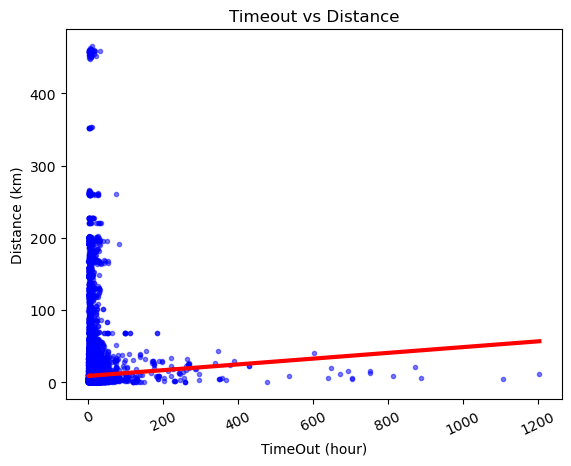

In [100]:
fit = stats.linregress(outages['timeOut'], outages['outageToSubstationDistance'])
plt.xticks(rotation = 25)
plt.plot(outages["timeOut"], outages["outageToSubstationDistance"], 'b.', alpha = 0.5)
plt.plot(outages["timeOut"], outages["timeOut"]*fit.slope + fit.intercept, 'r-', linewidth = 3)
plt.title('Timeout vs Distance')
plt.ylabel('Distance (km)')
plt.xlabel('TimeOut (hour)')
plt.show()
#this plot doesnt look good because the distance csv that I created was not very good. 
#it would be nice to try it on our actual big dataset and the corresponding distances csv

In [101]:
outages["timeOut"].corr(outages["outageToSubstationDistance"])

0.024684805110983775

### Trying transformations:

In [102]:
outages["timeOut"].apply(np.sqrt).corr(outages["outageToSubstationDistance"].apply(np.sqrt))

0.05617547867934283

### Log transformation:


In [103]:
outages["timeOut"].apply(np.log).corr(outages["outageToSubstationDistance"].apply(np.log))

0.04343142284024352

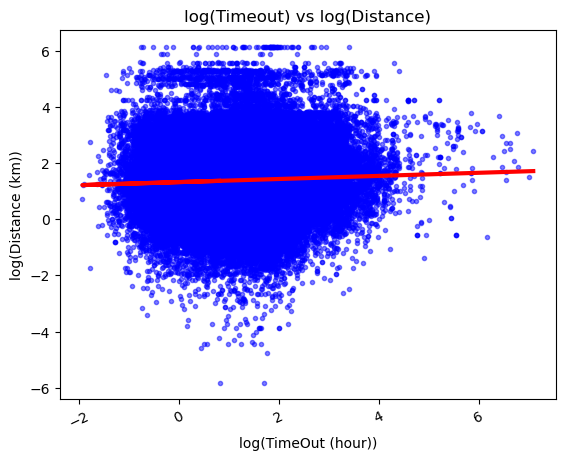

In [104]:
timeouts_transformed = outages["timeOut"].apply(np.log)
distance_transformed = outages["outageToSubstationDistance"].apply(np.log)
fit = stats.linregress(timeouts_transformed, distance_transformed)
plt.xticks(rotation = 25)
plt.plot(timeouts_transformed, distance_transformed, 'b.', alpha = 0.5)
plt.plot(timeouts_transformed, timeouts_transformed*fit.slope + fit.intercept, 'r-', linewidth = 3)
plt.title('log(Timeout) vs log(Distance)')
plt.ylabel('log(Distance (km))')
plt.xlabel('log(TimeOut (hour))')
plt.show()

Using log makes better bins as well! 
but are the bins even meaningful?

In [105]:
n = 10 #number of bins
distance_bins = pd.cut(outages['outageToSubstationDistance'].apply(np.log), bins=n)
outages['distance_bin'] = distance_bins
outages_per_dist = outages.groupby(['distance_bin']).size()
outages_per_dist = pd.DataFrame(outages_per_dist)
outages_per_dist = outages_per_dist.rename(columns={0:"#of outages"})
outages_per_dist

C:\Users\dorsa\AppData\Local\Temp\ipykernel_14928\2697302245.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outages_per_dist = outages.groupby(['distance_bin']).size()


,#of outages
distance_bin,
"(-5.826, -4.618]",3
"(-4.618, -3.423]",34
"(-3.423, -2.227]",132
"(-2.227, -1.031]",1297
"(-1.031, 0.164]",10780
"(0.164, 1.36]",37359
"(1.36, 2.556]",30083
"(2.556, 3.752]",12980
"(3.752, 4.947]",1419
